## Imports


In [20]:
import matplotlib

In [21]:
import sys
sys.path.append('/Users/pablojerezarnau/git/RS-backend/')

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from config.settings import TOPIC_MODELING_RUNS_DIR

## Load data


In [22]:

def load_run_data(run_id):
    """
    Load data from a given topic modeling run ID.

    Parameters:
    - run_id (str): The run ID (timestamp) to load data for.

    Returns:
    - A dictionary containing the loaded dataframes and topics.
    """
    run_path = os.path.join(TOPIC_MODELING_RUNS_DIR, run_id)

    data = {}  # Dictionary to store the loaded data

    # Load DataFrames
    for file_name in ['topic_distributions.json']:
        file_path = os.path.join(run_path, file_name)
        if os.path.exists(file_path):
            data[file_name.replace('.json', '')] = pd.read_json(
                file_path, lines=True)

    # Load topics
    topics_path = os.path.join(run_path, 'topics.json')
    if os.path.exists(topics_path):
        with open(topics_path, 'r') as file:
            data['topics'] = json.load(file)

    return data


run_id = '20240319_153921_dataset3_topics_300'
data = load_run_data(run_id)

# Analysing topics


In [23]:
# Define the number of topics you have
num_topics = len(data['topics'])

## Video count per topic


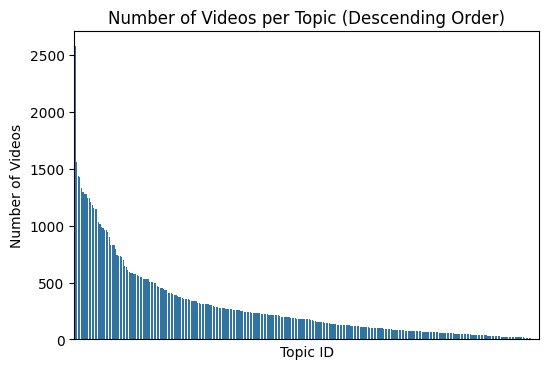

In [24]:
# Visualize the Number of Videos per Topic in Descending Order
def visualize_videos_per_topic(topic_modelling_df):
    # Get the counts of videos per topic and sort by counts in descending order
    topic_counts = topic_modelling_df['most_relevant_topic'].value_counts(
    ).sort_values(ascending=False)
    plt.figure(figsize=(6, 4))
    sns.barplot(x=topic_counts.index, y=topic_counts.values,
                order=topic_counts.index)
    plt.xlabel('Topic ID')
    plt.ylabel('Number of Videos')
    plt.xticks([])
    plt.title('Number of Videos per Topic (Descending Order)')
    plt.show()


visualize_videos_per_topic(data['topic_distributions'])

## t-SNE visualization


In [25]:
# Sample a subset of the data if necessary
n_samples = 10000  # for example, 10000 samples
np.random.seed(0)  # for reproducibility
sample_indices = np.random.choice(
    data['topic_distributions'].shape[0], n_samples, replace=False)
sampled_data = data['topic_distributions'].iloc[sample_indices]

# Preprocess with PCA to reduce the data to half of the dimensions
pca = PCA(n_components=round(num_topics/2))
pca_result = pca.fit_transform(sampled_data['topic_distribution'].tolist())

# Now run t-SNE
tsne = TSNE(n_components=2, random_state=0, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result)

KeyboardInterrupt: 

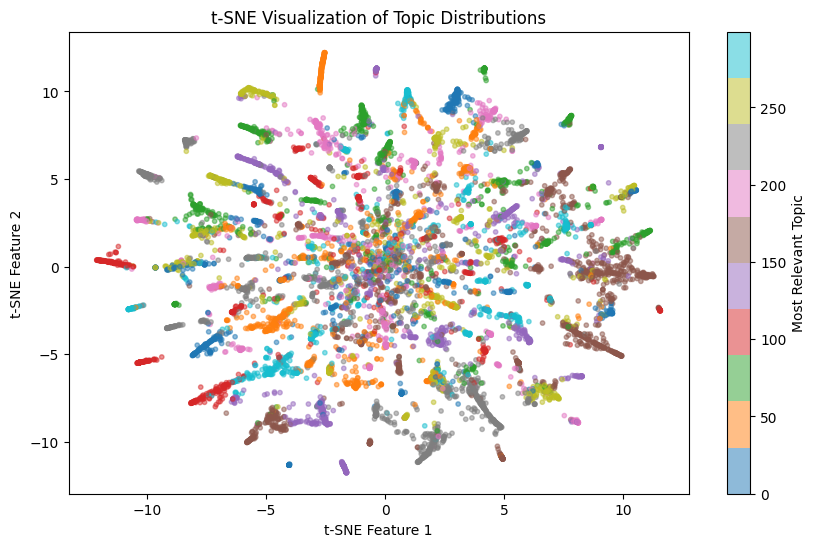

In [ ]:
# You also need to retrieve the most relevant topic for each document for coloring
most_relevant_topics = sampled_data['most_relevant_topic'].values

# Define color map
colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(most_relevant_topics))))

# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_pca_results[:, 0], tsne_pca_results[:, 1],
                      c=most_relevant_topics, cmap='tab10', alpha=0.5, s=10)

# Add a color bar for the scatter plot
colorbar = plt.colorbar(scatter)
colorbar.set_label('Most Relevant Topic')

# Set labels and title
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('t-SNE Visualization of Topic Distributions')

# Show the plot
plt.show()

## Topic tokens


In [ ]:
# Display the Words of Each Topic
def display_topic_words(topics):
    for topic in topics:
        print(f"Topic {topic['topic_number']}:")

        # Since each 'tokens' item is a dictionary, use .items() to iterate over key-value pairs
        words = ", ".join([word for token in topic['tokens'] for word, score in token.items()])
        
        print(words)
        print("\n")

# Assuming 'data['topics']' contains your topics data structure
display_topic_words(data['topics'])


Topic 158:
art, artist, martial, graffiti, satisfy, kick, sculpture, sketch, fight, artwork


Topic 220:
health, wellness, healthy, biohacke, dr, benefit, natural, janine, stress, nutrition


Topic 172:
music, hit, pop, relax, radio, playlist, sleep, production, live, mix


Topic 133:
film, indie, movie, cinematic, scene, trailer, fan, cinema, malayalam, political


Topic 238:
food, street, foodie, preservation, additive, cholesterol, high, storage, fast, coconut


Topic 271:
funny, china, moment, laugh, reaction, fun, comedy, try, cute, videos


Topic 151:
movie, hollywood, south, dub, recap, action, hindi, scifi, trailer, fi


Topic 150:
idea, gift, card, bottle, birthday, plastic, creative, decor, team, room


Topic 184:
technology, blockchain, future, smart, reality, augment, computer, ar, way, tool


Topic 10:
travel, destination, guide, solo, budget, safety, trip, time, place, explore


Topic 40:
chess, opening, checkmate, trap, tactic, puzzle, move, strategy, play, magnus


Topi

### Topic word clouds


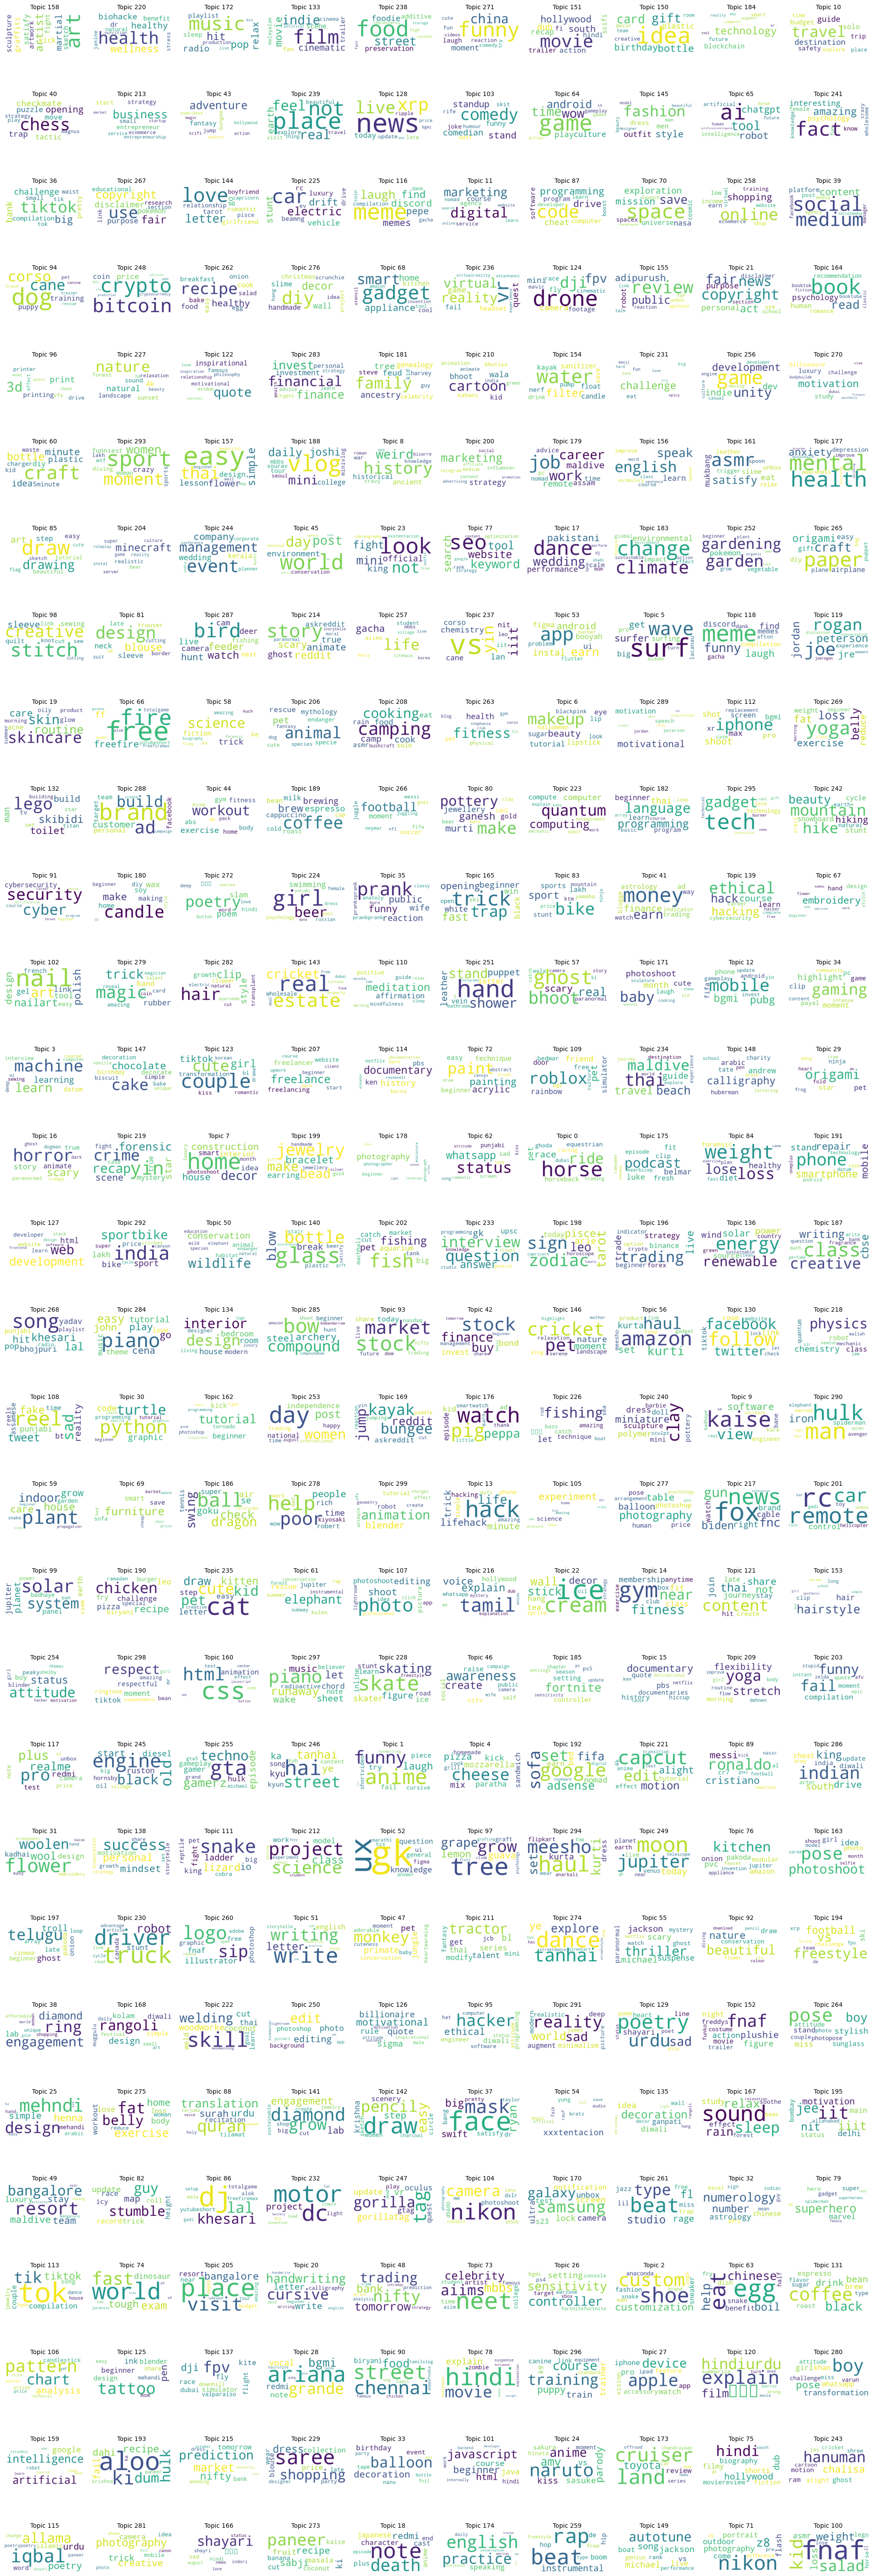

In [ ]:
# Assuming 'data['topics']' is structured correctly and 'num_topics' is defined
cols = 10  # Adjust the number of columns as needed
rows = num_topics // cols + (num_topics % cols > 0)

# Generate word clouds for each topic and display them in a grid
fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows), dpi=100)  # Adjust size as needed

# Flatten axes array if necessary
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i, topic in enumerate(data['topics']):
    # Correctly generate the word frequency dictionary
    word_freq = {word: freq for token_dict in topic['tokens'] for word, freq in token_dict.items()}
    
    wordcloud = WordCloud(background_color='white', max_words=50, collocations=False).generate_from_frequencies(word_freq)

    # Display the word cloud
    ax = axes[i] if i < len(axes) else plt.gca()  # Get the appropriate subplot axis or the current axis if out of bounds
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')  # Hide the axes
    ax.set_title(f"Topic {topic['topic_number']}", size=10)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Heat meap of topic distributions


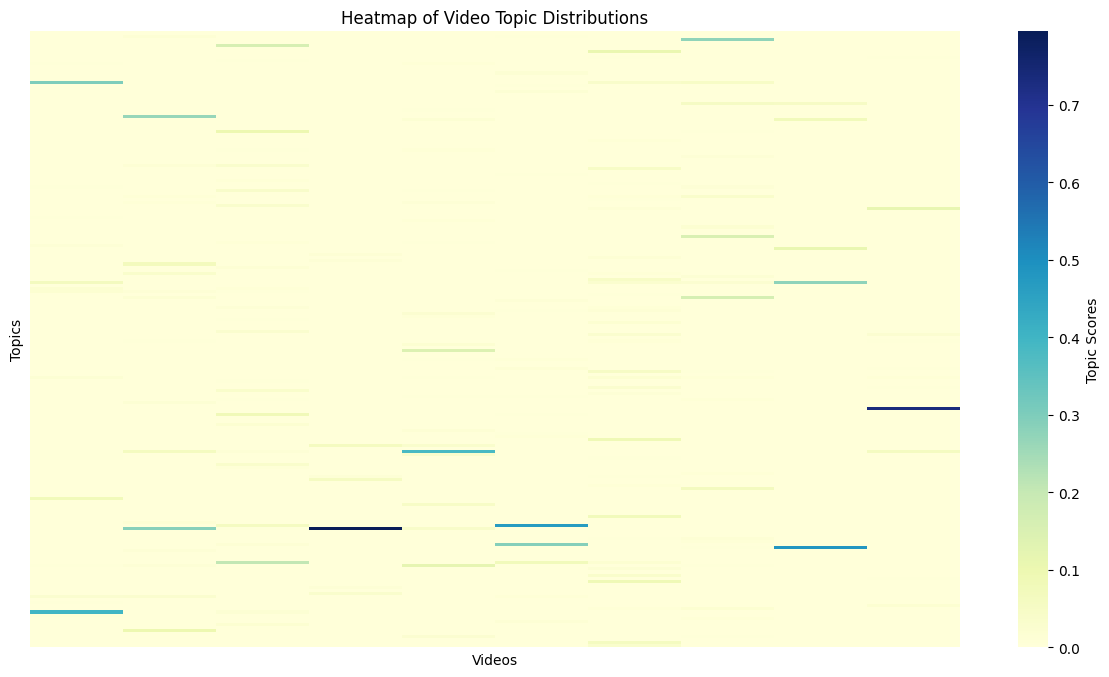

In [ ]:
def visualize_topic_distribution_heatmap(df, n_samples=50):
    # Sample a subset of the dataframe
    sampled_df = df.sample(n_samples)

    # Assuming 'topic_distribution' is a list of topic probabilities
    topic_distribution_matrix = sampled_df['topic_distribution'].apply(
        pd.Series)

    # Plotting the heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(topic_distribution_matrix.T, cmap='YlGnBu',
                cbar_kws={'label': 'Topic Scores'})
    plt.title('Heatmap of Video Topic Distributions')
    plt.xlabel('Videos')
    plt.ylabel('Topics')
    plt.xticks([])
    plt.yticks([])
    plt.show()


# Call the function with the eligible videos dataframe
visualize_topic_distribution_heatmap(data['topic_distributions'], n_samples=10)

# Understanding topic distributions

In [ ]:
# Convert the list of topic scores into a DataFrame
df = data['topic_distributions']
topic_scores_df = pd.DataFrame(df['topic_distribution'].tolist())

## 1. Histogram of Dominant Topic Scores

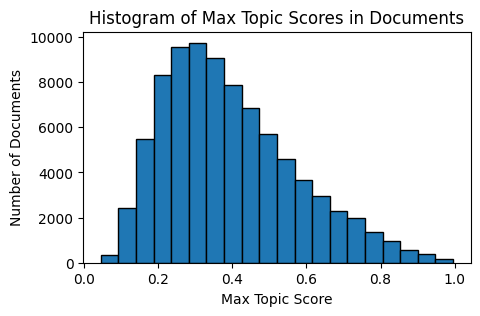

In [ ]:
import numpy as np

# Assuming 'topic_distribution' is a column in your DataFrame with each row containing a list of topic scores
max_topic_scores = df['topic_distribution'].apply(lambda x: np.max(x))

plt.figure(figsize=(5, 3))
plt.hist(max_topic_scores, bins=20, edgecolor='black')
plt.title('Histogram of Max Topic Scores in Documents')
plt.xlabel('Max Topic Score')
plt.ylabel('Number of Documents')
plt.show()

## 2. Box Plot of Topic Scores

KeyboardInterrupt: 

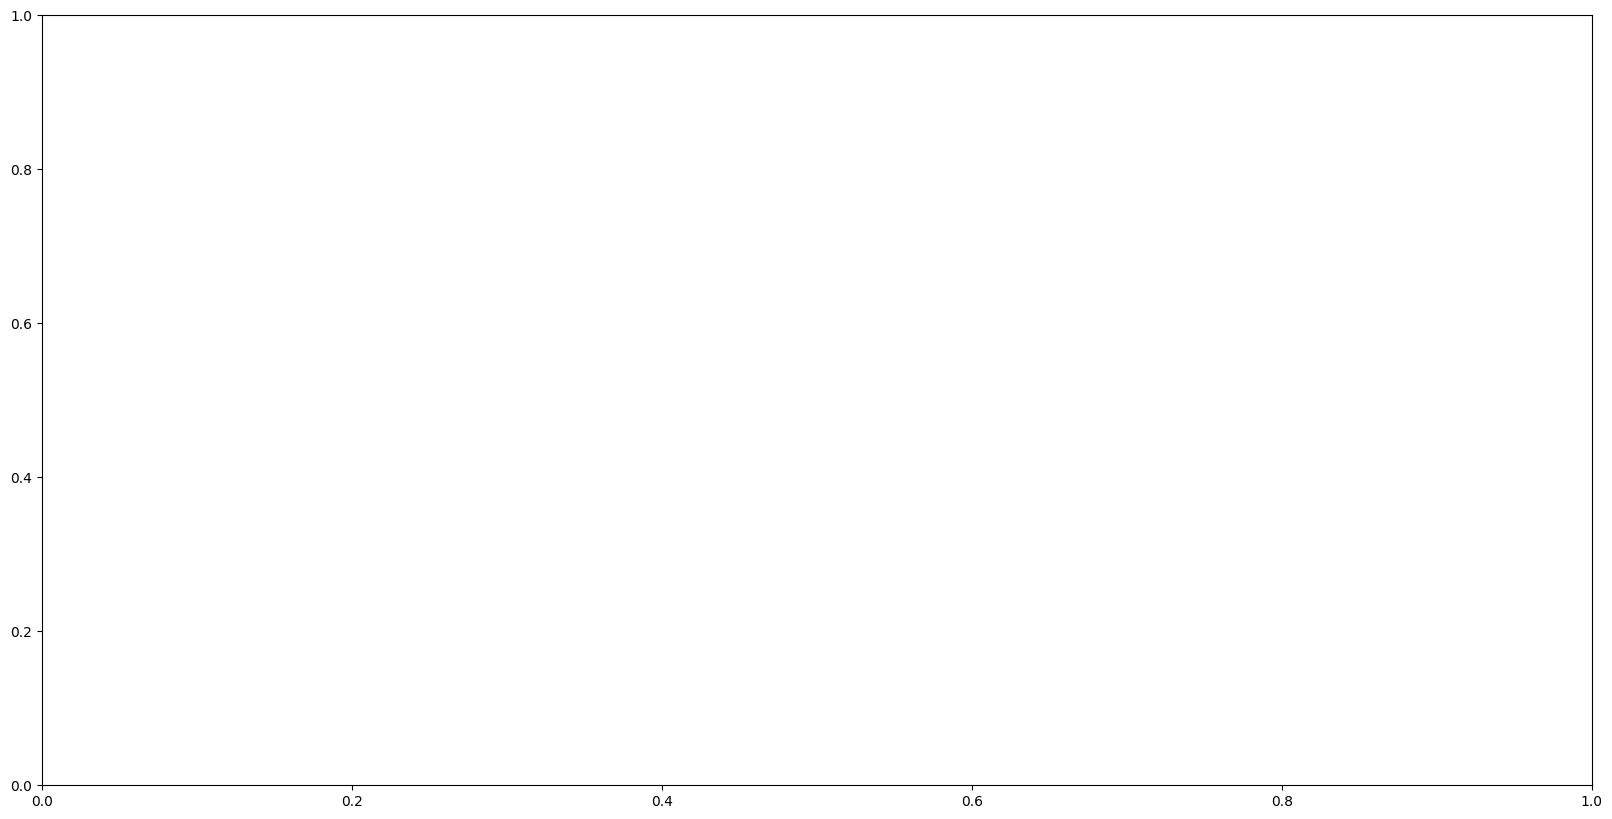

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate the number of topics
num_topics = len(topic_scores_df.columns)

# Increase the figure size for better readability
plt.figure(figsize=(20, 10))

# Create the boxplot with seaborn
sns.boxplot(data=topic_scores_df)

# Set the title and labels
plt.title('Box Plot of Topic Scores Across Documents')
plt.xlabel('Topic')
plt.ylabel('Score')

# Set x-tick labels. If there are too many topics, you might want to display only a subset of labels.
xticks = range(0, num_topics, 10)  # Adjust the step as needed
plt.xticks(xticks, xticks, rotation=90, fontsize=8)  # Rotate for better readability

# Show the plot
plt.show()


## 3. Sparsity Analysis

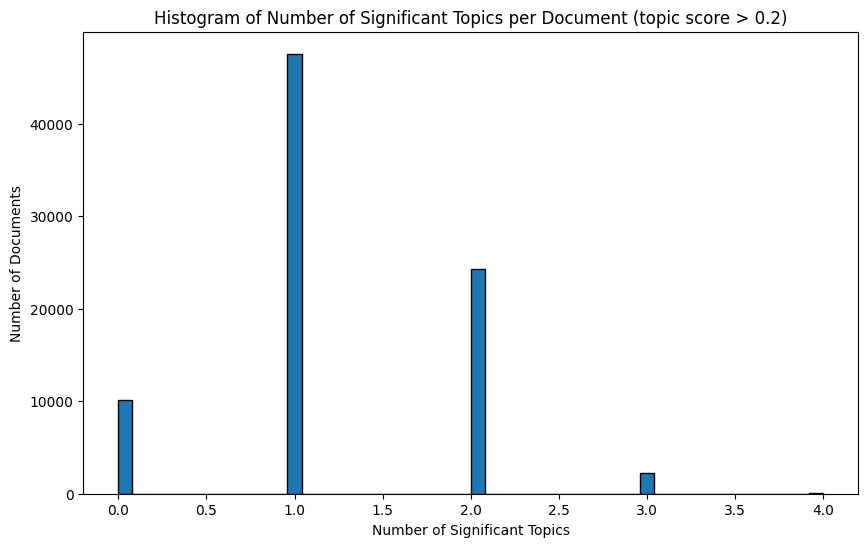

In [ ]:
threshold = 0.2  # Define a threshold for considering a topic score as significant

# Calculate the percentage of significant topics per document
significant_topics_per_doc = df['topic_distribution'].apply(lambda x: np.sum(np.array(x) > threshold))

plt.figure(figsize=(10, 6))
plt.hist(significant_topics_per_doc, bins=50, edgecolor='black')
plt.title(f'Histogram of Number of Significant Topics per Document (topic score > {threshold})')
plt.xlabel('Number of Significant Topics')
plt.ylabel('Number of Documents')
plt.show()

## Top-10 topic scores of a document

In [ ]:
import pandas as pd
import numpy as np

# Helper function to get the top-5 topics and their scores
def get_top_topics_scores(doc_topic_distribution):
    # Sort the topic distribution scores in descending order
    sorted_topics = sorted(enumerate(doc_topic_distribution), key=lambda x: x[1], reverse=True)
    # Get the top-5 topics and their scores
    return sorted_topics[:5]

# Function to get the most relevant topic and its percentile ranking among documents with the same topic
def get_relevance_info(document_index, df):
    doc_topic_distribution = df.iloc[document_index]['topic_distribution']
    most_relevant_topic_index = df.iloc[document_index]['most_relevant_topic']
    most_relevant_topic_score = doc_topic_distribution[most_relevant_topic_index]

    # Get all documents with the same most relevant topic
    same_topic_docs = df[df['most_relevant_topic'] == most_relevant_topic_index]
    topic_scores = same_topic_docs['topic_distribution'].apply(lambda x: x[most_relevant_topic_index])

    # Calculate the percentile of the score
    percentile = (topic_scores > most_relevant_topic_score).sum() / len(topic_scores) * 100

    # Get the top-5 topics and their scores for the document
    top_topics_scores = get_top_topics_scores(doc_topic_distribution)

    return most_relevant_topic_index, most_relevant_topic_score, percentile, top_topics_scores

# Assuming df is your dataframe with 'topic_distribution' and 'most_relevant_topic' columns
# Sample three random documents
sampled_docs = df.sample(3)

# Process each sampled document
for idx in sampled_docs.index:
    topic_index, topic_score, percentile, top_topics_scores = get_relevance_info(idx, df)
    print(f"Document {idx}:")
    print(f"Most relevant topic: {topic_index} with score {topic_score:.2f}")
    print(f"Percentile ranking among documents with this topic: {percentile:.2f}")
    print("Top 5 Topics and Scores:")
    for topic, score in top_topics_scores:
        print(f"  Topic {topic}: {score:.3f}")
    print("\n")


Document 9524:
Most relevant topic: 172 with score 0.17
Percentile ranking among documents with this topic: 96.77
Top 5 Topics and Scores:
  Topic 172: 0.173
  Topic 79: 0.137
  Topic 112: 0.120
  Topic 140: 0.038
  Topic 10: 0.037


Document 56191:
Most relevant topic: 188 with score 0.33
Percentile ranking among documents with this topic: 54.84
Top 5 Topics and Scores:
  Topic 188: 0.327
  Topic 16: 0.301
  Topic 172: 0.253
  Topic 160: 0.039
  Topic 139: 0.022


Document 10530:
Most relevant topic: 58 with score 0.36
Percentile ranking among documents with this topic: 54.32
Top 5 Topics and Scores:
  Topic 58: 0.363
  Topic 134: 0.171
  Topic 194: 0.133
  Topic 156: 0.115
  Topic 38: 0.033




# Analysis of topics scores per topics

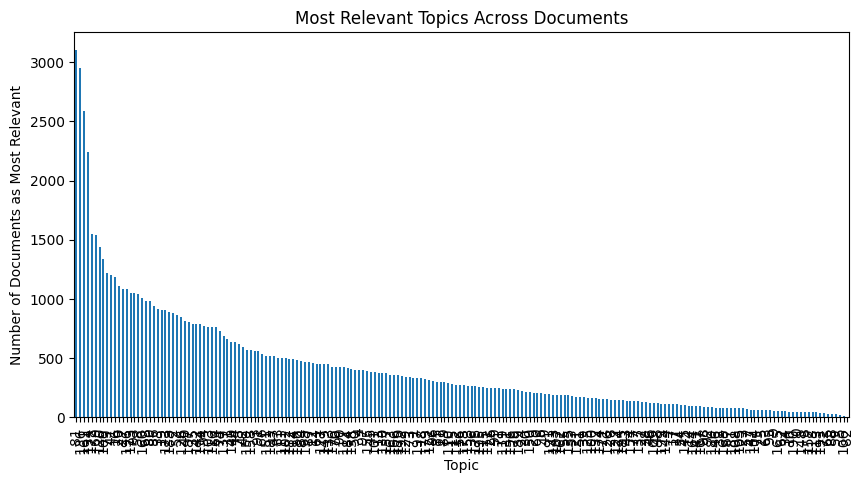

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame and it contains a 'topic_distribution' column
# where each entry is a list of topic scores for a document.

# Step 1: Identify the most relevant topic for each document
df['most_relevant_topic'] = df['topic_distribution'].apply(lambda scores: scores.index(max(scores)))

# Step 2: Count how many times each topic is the most relevant
topic_counts = df['most_relevant_topic'].value_counts().sort_values(ascending=False)

# Step 3: Plot the histogram
plt.figure(figsize=(10, 5))
topic_counts.plot(kind='bar')
plt.title('Most Relevant Topics Across Documents')
plt.xlabel('Topic')
plt.ylabel('Number of Documents as Most Relevant')
plt.show()


# Video examples for each topic


In [ ]:
# Print a Few Videos for Each Topic with formatted output
def print_videos_for_each_topic(topic_modelling_df, n_samples=5, title_width=60):
    for topic in data['topics']:
        topic_number = topic['topic_number']
        topic_words = ", ".join([word for token in topic['tokens'] for word, score in token.items()])
        print(f"\nTopic {topic_number} ({topic_words}):\n")
        sample_videos = topic_modelling_df[topic_modelling_df['most_relevant_topic'] == topic_number].sample(
            n=n_samples, replace=True)

        for _, row in sample_videos.iterrows():
            # Format the title to have a constant width for alignment
            title_formatted = row.get('title', 'N/A')
            link_formatted = row.get('link', 'N/A')
            id = row.get('id', 'N/A')
            # Adjust the formatting here to pad or truncate the title as necessary
            print(
                f"{title_formatted:{title_width}.{title_width}} {link_formatted} {id}")

        # Add a newline for spacing between topics
        print()


# Assuming 'topics' contains the topic words data loaded previously
print_videos_for_each_topic(data['topic_distributions'])


Topic 81 (game, time, wow, android, culture, unity, gaming, gameplay, play, roblox):

Tuto kick skill (Fifa mobile) #gaming #fifamobile #soccer #f https://www.youtube.com/watch?v=Sb6JVPq4cTg Sb6JVPq4cTg
I Played Warzone With My Son...                              https://www.youtube.com/watch?v=oRPDqnEZ278 oRPDqnEZ278
[UPDATED] 18th Birthday Party Plan (Sonic SFM Animatic Short https://www.youtube.com/watch?v=ysHiONFYVXI ysHiONFYVXI
The Amazing Pea Zombie - Plants vs Zombies #shorts #pvzmods  https://www.youtube.com/watch?v=arQZ4yYzhGs arQZ4yYzhGs
Thinking Every Restaurant Has A Secret Menu                  https://www.youtube.com/watch?v=_E7h0I2oas8 _E7h0I2oas8


Topic 136 (social, medium, marketing, content, strategy, platform, training, facebook, post, influencer):

Bungee jumping, Adventure #shorts #bungeejumping #adventure  https://www.youtube.com/watch?v=7XdmsM5CuDQ 7XdmsM5CuDQ
WAIT FOR IT... Crazy Ocean Waves of Los Cabos Mexico #travel https://www.youtube.com/watch?v=ZfnjqgNOl

In [26]:
def print_videos_for_topic(topic_modelling_df, topic_index, n_samples=10, title_width=60):
    """
    Print a few videos for a specific topic with formatted output.

    Parameters:
    - topic_modelling_df (DataFrame): DataFrame containing video data and most relevant topic information.
    - topic_index (int): Index of the topic for which videos are to be printed.
    - n_samples (int): Number of sample videos to print for the topic. Default is 5.
    - title_width (int): Width of the title column for alignment. Default is 60.
    """
    topic_data = topic_modelling_df[topic_modelling_df['most_relevant_topic'] == topic_index]
    if topic_data.empty:
        print(f"No videos found for topic {topic_index}.")
        return

    print(f"\nVideos for Topic {topic_index}:\n")
    for _, row in topic_data.sample(n=n_samples, replace=True).iterrows():
        title_formatted = row.get('title', 'N/A')
        link_formatted = row.get('link', 'N/A')
        id_formatted = row.get('id', 'N/A')
        print(f"{title_formatted:{title_width}.{title_width}} {link_formatted} {id_formatted}")

    print()  # Add a newline for spacing

# Assuming 'topic_modelling_df' contains the DataFrame with video data and most relevant topic information
topic_index = 17
print_videos_for_topic(data['topic_distributions'], topic_index=topic_index)



Videos for Topic 17:

Manali Budget Trip Under 5000/- Rupees 💸💸💸 #shorts #travel   https://www.youtube.com/watch?v=b3BFjavAn9Q b3BFjavAn9Q
Power Paragliding #india #ytshorts #incredibleindia #travel  https://www.youtube.com/watch?v=BXAdGYGnyn4 BXAdGYGnyn4
High-Altitude Kayaking: Paddling Norway's Glacial Blues 🇳🇴   https://www.youtube.com/watch?v=25Q-Ow41hY4 25Q-Ow41hY4
It all about balance 👩‍💻🌎✈ #shorts #shortsvideo #trending #t https://www.youtube.com/watch?v=X2PPtGwqfwg X2PPtGwqfwg
Van lifestyle food  #shorts                                  https://www.youtube.com/watch?v=8rRDZ-cuvsA 8rRDZ-cuvsA
Traveling with the wind #shorts                              https://www.youtube.com/watch?v=jry-k-ee_xM jry-k-ee_xM
You Only Get 75 Years... #hiking #nationalpark #shorts #subs https://www.youtube.com/watch?v=l7Acri4tNJc l7Acri4tNJc
DJIMini3Pro #shorts #djimini3pro #dronevideo #drone #drones  https://www.youtube.com/watch?v=A72Ng0MT3qs A72Ng0MT3qs
Experience the luxury of skiing in the Sw